# The Positive List

In 2008 the VKO government introduced a way for people from non EU countries to migrate to Denmark in areas of skills shortage.

At first the scheme was for so-called highly educated foreigners but in 2020 was expanded to include other skilled professions in areas such as healthcare and construction. 

It costs over 6000 kroner for an application to be accepted on this scheme.


## Rejections
There are rules about income to prevent "social dumping" (where foreigners get worse working conditions and pay than locals). The wording is that the salary should be "ordinary", compared to national pay statistics. This means that some people are rejected because their compensation would be higher than ordinary. There have been some cases in the media about this rule making it difficult for employers to recruit in skills shortage areas. (https://ekstrabladet.dk/nyheder/samfund/straffet-for-at-give-ansat-mere-i-loen/8964271)


## Throat Clearing
* Despite being made for "third country" (as in, non-EU, non-Nordic) immigration, some EU and Nordic migrants have been accepted, presumably for the sake of their third country spouses. 

Some people commute into Denmark on this scheme, so have not migrated into Denmark as such. Some do not have full time employment on this scheme. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_high = pd.read_csv('hojuddannede.csv', encoding='utf-8')
df_skilled = pd.read_csv('faglaert.csv', encoding='utf-8')

df_high.head()

,Branche,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,"Landbrug, skovbrug og fiskeri",.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
1,Råstofindvinding,42,41,30,23,16,10,3,.,.,.,.,.,.,.,.,.
2,Industri,220,172,144,97,85,63,42,39,37,45,64,70,56,59,61,55
3,Energiforsyning,4,4,.,.,.,.,.,.,.,.,.,3,3,3,3,3
4,Vandforsyning og renovation,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.


In [3]:
# Translation mapping for the branches
translation_mapping = {
    'Landbrug, skovbrug og fiskeri': 'Agriculture, Forestry, and Fishing',
    'Råstofindvinding': 'Mining',
    'Industri': 'Industry',
    'Energiforsyning': 'Energy Supply',
    'Vandforsyning og renovation': 'Water Supply and Waste Management',
    'Bygge og anlæg': 'Construction',
    'Handel': 'Trade',
    'Transport': 'Transport',
    'Hoteller og restauranter': 'Hotels and Restaurants',
    'Information og kommunikation': 'Information and Communication',
    'Finansiering og forsikring': 'Finance and Insurance',
    'Ejendomshandel og udlejning': 'Real Estate and Renting',
    'Videnservice': 'Knowledge Services',
    'Rejsebureau, rengøring o.a. operationel service': 'Travel Agency, Cleaning, and Other Services',
    'Offentlig administration, undervisn. og sundhed': 'Public Administration, Education, and Health',
    'Kultur og fritid': 'Culture and Leisure',
    'Andre serviceydelser mv.': 'Other Services',
    'Uoplyst aktivitet': 'Unspecified Activity'
}

# Apply the translation mapping
df_high['Branche'] = df_high['Branche'].map(translation_mapping)


<Figure size 1000x600 with 0 Axes>

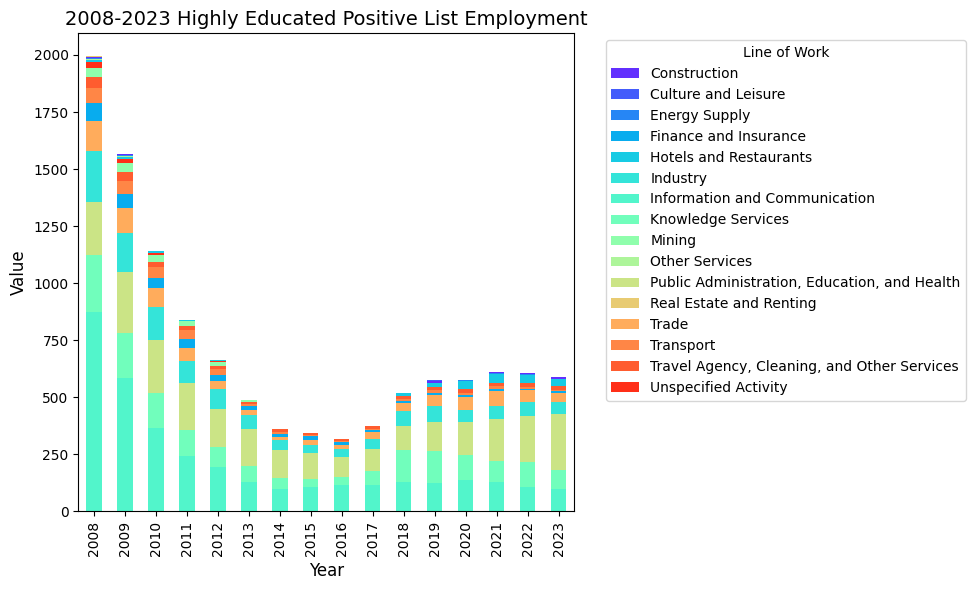

In [4]:
# Replace "." with NaN and convert columns from 2008-2023 to numeric
years = list(map(str, range(2008, 2024)))  # List of years from 2008 to 2023
df_high[years] = df_high[years].replace('.', pd.NA)  # Replace "." with NaN
df_high[years] = df_high[years].apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coercing errors

# Filter out industries that have no data across all years
df_filtered = df_high.dropna(how='all', subset=years)

# Sort by the 2008 column (largest first) for the stacked bar chart
df_sorted = df_filtered.sort_values(by='2008', ascending=False)

# Set 'Branche' as the index
df_sorted.set_index('Branche', inplace=True)

# Sort Branche names alphabetically to assign rainbow colors correctly
alphabetical_branches = sorted(df_sorted.index)

# Create a rainbow palette and assign it to the alphabetically sorted Branche names
rainbow_colors = sns.color_palette("rainbow", n_colors=len(alphabetical_branches))
color_mapping = {branche: color for branche, color in zip(alphabetical_branches, rainbow_colors)}

# Create a stacked bar chart with colors mapped in value order but rainbow colors in alphabetical order
plt.figure(figsize=(10, 6))

# Use the sorted colors in the bar plot based on the original value-sorted df_sorted
ax = df_sorted[years].T.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6), 
    color=[color_mapping[branche] for branche in df_sorted.index]
)

# Add labels and title
plt.title('2008-2023 Highly Educated Positive List Employment', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Get handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Sort the legend alphabetically by the labels (using the same alphabetical order for legend)
sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: x[0])

# Unzip the sorted handles and labels
sorted_labels, sorted_handles = zip(*sorted_handles_labels)

# Add the sorted legend back to the plot with the correct colors in rainbow order
plt.legend(sorted_handles, sorted_labels, title='Line of Work', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


In [5]:
import plotly.graph_objects as go

# Replace "." with NaN and convert columns from 2008-2023 to numeric
years = list(map(str, range(2008, 2024)))
df_high[years] = df_high[years].replace('.', pd.NA)
df_high[years] = df_high[years].apply(pd.to_numeric, errors='coerce')

# Filter out industries that have no data across all years
df_filtered = df_high.dropna(how='all', subset=years)

# Sort by the 2008 column (largest first)
df_sorted = df_filtered.sort_values(by='2008', ascending=False)

# Set 'Branche' as the index
df_sorted.set_index('Branche', inplace=True)

# Sort Branche names alphabetically to assign rainbow colors correctly
alphabetical_branches = sorted(df_sorted.index)

# Create a rainbow palette and assign it to the alphabetically sorted Branche names
rainbow_colors = sns.color_palette("rainbow", n_colors=len(alphabetical_branches))
color_mapping = {branche: f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})' for branche, (r, g, b) in zip(alphabetical_branches, rainbow_colors)}

# Create a stacked bar chart with Plotly
fig = go.Figure()

# Add a bar trace for each Branche (stacked by year)
for branche in df_sorted.index:
    fig.add_trace(go.Bar(
        x=years,
        y=df_sorted.loc[branche, years],
        name=branche,
        marker_color=color_mapping[branche],
        hovertemplate=f'<b>{branche}</b><br>Year: %{x}<br>Value: %{y}<extra></extra>'
    ))

# Customize the layout
fig.update_layout(
    barmode='stack',
    title='2008-2023 Highly Educated Positive List Employment',
    xaxis_title='Year',
    yaxis_title='Value',
    legend_title='Line of Work',
    hovermode="x unified"  # This will show a unified tooltip for all categories at each x (year) point
)

# Show the plot
fig.show()


ModuleNotFoundError: No module named 'plotly'

<Figure size 1200x600 with 0 Axes>

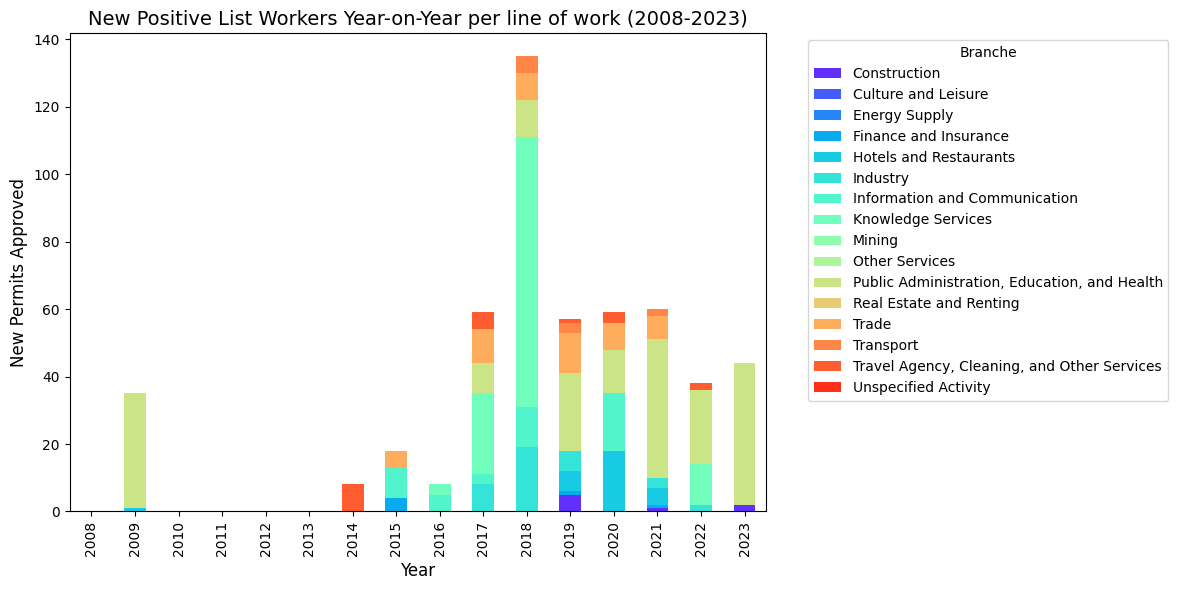

In [20]:
# Calculate the year-on-year changes (difference between consecutive years)
df_changes = df_filtered.set_index('Branche').diff(axis=1)

# Replace negative changes with 0 (so only positive changes are shown)
df_changes[df_changes < 0] = 0

# Sort each year from largest to smallest
df_changes_sorted = df_changes.apply(lambda x: x.sort_values(ascending=False), axis=0)


colors = sns.color_palette("rainbow", n_colors=len(df_filtered))

# Create the stacked bar chart
plt.figure(figsize=(12, 6))

# Plot the stacked bar chart
df_changes_sorted.T.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

# Add labels and title
plt.title('New Positive List Workers Year-on-Year per line of work (2008-2023)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('New Permits Approved', fontsize=12)
plt.legend(title='Branche', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better visibility
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/np/58k3dprd65g92cgj2g87m0gh0000gn/T/ipykernel_20660/3819446392.py:49: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/np/58k3dprd65g92cgj2g87m0gh0000gn/T/ipykernel_20660/3819446392.py:49: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/np/58k3dprd65g92cgj2g87m0gh0000gn/T/ipykernel_20660/3819446392.py:49: UserWarning: Glyph 128736 (\N{HAMMER AND WRENCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/np/58k3dprd65g92cgj2g87m0gh0000gn/T/ipykernel_20660/3819446392.py:49: UserWarning: Glyph 127869 (\N{FORK AND KNIFE WITH PLATE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/np/58k3dprd65g92cgj2g87m0gh0000gn/T/ipykernel_20660/3819446392.py:49: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/np/58k3dprd65g92cgj2g87m0gh0

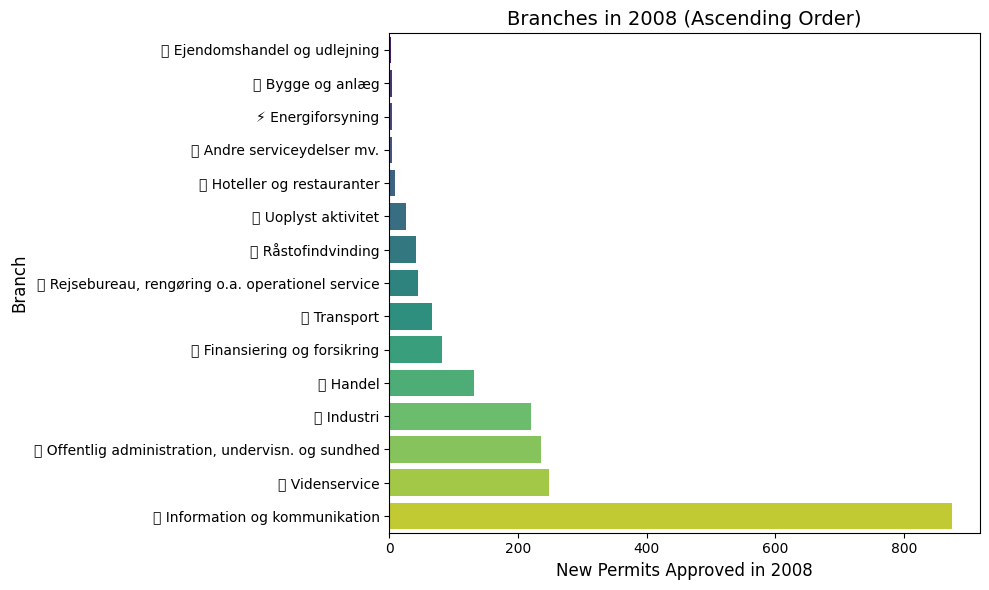

In [15]:


# Replace "." with NaN and convert 2008 column to numeric
df_filtered.loc[:, '2008'] = df_filtered['2008'].replace('.', pd.NA)  # Replace "." with NaN
df_filtered.loc[:, '2008'] = pd.to_numeric(df_filtered['2008'], errors='coerce')  # Convert to numeric

# Filter out rows where 2008 data is missing
df_2008 = df_filtered[['Branche', '2008']].dropna()

# Sort the data by 2008 in ascending order
df_2008_sorted = df_2008.sort_values(by='2008', ascending=True)


plt.figure(figsize=(10, 6))
sns.barplot(x='2008', y='Branche', hue='Branche', data=df_2008_sorted, palette='viridis', legend=False)

# Add labels and title
plt.title('Branches in 2008 (Ascending Order)', fontsize=14)
plt.xlabel('New Permits Approved in 2008', fontsize=12)
plt.ylabel('Branch', fontsize=12)

plt.tight_layout()
plt.show()